# Using Convolutional Neural Networks

## Introduction to assignment: 'Dogs vs Cats'

This is my solution to the first asignment for [Deep Learning For Coders, Part 1](http://course.fast.ai/) from [fast.ai](http://www.fast.ai/). There are many [tasks](http://wiki.fast.ai/index.php/Lesson_1) for week one which include setting up computing resources and learning from prebuilt classes, but this will contain only my solution to the following problem:

**from course notebook:**
*We're going to try to create a model to enter the [Dogs vs Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as of 2013!*

### tasks:

**vgg setup:**
- import relevant modules for setup
- setup mappings for classes -> taken directly from fast.ai
- make wrapper functions for conv & fully connected layers
- make function to build full VGG model
- get pre-trained weights for VGG ImageNet model

**transfer-learning:**
- create batches of training data 
- add new layer to model
- train model on kaggle data
- evaluate kaggle predictions
- write the test predictions to a properly formatted kaggle submission

## Setup
add data path and load in some nice utility functions for loading/storing numpy arrays and plotting images

In [20]:
# path = "data/redux/"
path = "data/redux/sample/"
data_path = "data/redux/"
results_path = "data/redux/results/"
valid_path = "data/redux/valid/"

In [2]:
# add utils dir
import sys; sys.path.append('../utils/')

import utils; reload(utils)
from utils import plots

Using Theano backend.


# Creating the VGG model from scratch in Keras

Here is the link to the original paper, [*Very Deep Convolutional Networks for Large-Scale Image Recognition*](https://arxiv.org/abs/1409.1556), which won ImageNet in 2014. The paper discusses a network structure composed of small convolutional filters (3 X 3). Below is the network structure that we will build in keras. This diagram is a bit confusing but the column that has the full network information is column **E**. Here is the table caption from the original paper:

>**The depth of the configurations increases from the left (A) to the right (E), as more layers are added (the added layers are shown in bold). The convolutional layer parameters are denoted as “conv(receptive field size, number of channels)”. The ReLU activation function is not shown for brevity.**


![convnet](data/redux/convnet.png)

## Model setup

In [25]:
%matplotlib inline
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import json
import numpy as np

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [6]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

examples of classes from ImageNet

In [8]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model creation

Below we define wrappers for creating keras layers in our model. All the convolution layers are the same size so the only parameters at each step are the *number of layers*, which can be summarized as the number of rows from the convnet diagram above, and *number of channels* which begins at 64 and increases by a factor of two. Two fully connected layers and then a final fully connected layer are used to reduce the convolution output to the label dimensions.

In [9]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [10]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

To match the results from the original paper, we need to de-mean (not demean lol) the image rgb-channels. This is a normalizing technique that will help the network train with more stability.

**from course notebook:**
*When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:*

In [13]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Below we define the keras model structure where each layer is being added by our helper functions defined above.

In [14]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

**from course notebook:**

*We'll learn about what these different blocks do later in the course. For now, it's enough to know that:*

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

*Now that we've defined the architecture, we can create the model like any python object:*

In [15]:
model = VGG_16()

here we will just download the pretrained weights from the fast AI course because I don't want to spend the money or the time to retrain the VGG model and reproduce results from 2014. This step isn't important because our solution will really fall under the category of *transfer learning*

In [16]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

Here we can use a utility function that wraps the method *flow_from_directory(directory)* from *keras.preprocessing.image.ImageDataGenerator* so that we can create an iterator for the training images that we have to work with succinctly.

In [17]:
batch_size = 4

In [18]:
def get_batches(dirname, path,gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


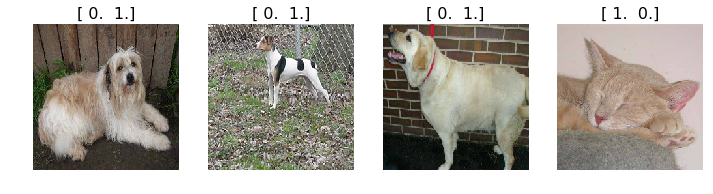

In [27]:
batches = get_batches('train', path, batch_size=batch_size)
val_batches = get_batches('valid', path, batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 "probabilities" for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [28]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.2f} / {}'.format(preds[i, idx], classes[idx]))

In [31]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.6185e-07   5.9966e-07   1.9919e-05   1.0729e-05   2.8389e-05]

Predictions prob/class: 
  0.27 / Siberian_husky
  0.33 / tabby
  0.29 / Saint_Bernard
  0.30 / tiger_cat


# Creating cat-doj predictions

Below we see a keras model summary that matches the VGG model table from before and has the pre-trained weights loaded so that it is a replica of the model used in the ImageNet competiton.

In [32]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

This is the meat of the assignment and includes code that should be run on the gpu since it is computationally intensive. Essentially what needs to be done is to train a new fully connected layer on the sample of data that we were given by the kaggle competition (25,000 cat & dog images). 

Here is the idea for using transfer learning: 
1. The network already 'understands' what cats and dog's are but it is too specific in the type of dog or cat for our predictions
2. We need to replace the last layer in our model with one that takes the VGG ImageNet 'probabiliy' predictions and returns a cat dog vector
3. Once this layer is added we fit the new model on our new data and evaluate it's performance on the training + validation data

In [30]:
# remove final model layer
model.pop()
# !!!make sure to not retrain entire model!!!
for layer in model.layers: layer.trainable=False
# replace the final layer with one that converts 1000 ImageNet classes to cat-doj labels
model.add(Dense(batches.nb_class, activation='softmax'))

Once the new model structire is 

In [31]:
# compile the model layer
model.compile(optimizer=SGD(lr=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

classes = list(iter(batches.class_indices))
# grab classes
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
model.classes = classes

The actual fitting of the model was done on a gpu where the new last layer weights were cached after every training epoch. I trained this model for 3 epochs with a batch size of 32 photos which took about an hour.

In [35]:
# # fit the new model
# no_of_epochs = 32
# latest_weights_filename = None
# for epoch in range(no_of_epochs):
#     print "Running epoch: %d" % epoch
#     vgg.fit(batches, val_batches, nb_epoch=1)
#     latest_weights_filename = 'ft%d.h5' % epoch
#     vgg.model.save_weights(results_path+latest_weights_filename)
# print "Completed %s fit operations" % no_of_epochs

In [36]:
# # cache the model weights so we don't have to retrain each time
# model.save_weights('data/dogscats/weights/vgg_sm_train.h5')

Here we are loading the weights that were created from running the model on the gpu

In [32]:
model.load_weights('data/redux/results/ft2.h5')

ValueError: You are trying to load a weight file containing 16 layers into a model with 17 layers.

## Evaluate Predictions

*These functions were taken from the redux notebook because my initial week 1  solution was just a submission that beat the required accuracy threshold*


In [33]:
# val_batches = get_batches(valid_path)
# probs = model.predict_generator(val_batches, batch_size = batch_size)

filenames.dat  ft0.h5  ft1.h5  ft2.h5  test_preds.dat


# Generate predictions on test data

In [40]:
# generate predicions on test data for submission
tst_gen = image.ImageDataGenerator()
tst_data = tst_gen.flow_from_directory(directory=data_path+'test/unknown',
                                       shuffle=False,
                                       batch_size=batch_size,
                                       class_mode=None, 
                                       target_size=(224,224))

Found 12500 images belonging to 1 classes.


In [41]:
# computationally intensive task -- takes like a few hours on cpu thread -- use gpu
# file_names 
# preds = model.predict_generator(tst_data, tst_data.nb_sample)

In [42]:
# save last result to disk -- !important
# from utils import save_array
# save_array(results_path + 'test_preds.dat', preds)
# save_array(results_path + 'filenames.dat', filenames)

# Format Predictions

Here is the format that is required by kaggle to score submission:

    id,label
    1242, .3984
    3947, .1000
    4539, .9082
    2345, .0000

So we need to grab the file ids and the predictid probability for dogs and put them into a single file with the column headers ['id', 'label']

In [65]:
# reload predictions
from utils import load_array
tst_data = load_array(data_path+'preds/filenames.dat')
preds = load_array(data_path+'preds/tst_preds.dat')

In [74]:
tst_data = list(tst_data)
get_number = lambda x: int(x[x.find('/')+1:x.find('.')])
img_id = map(get_number, tst_data)

In [86]:
pdog = preds[:,1]
img_id = np.asarray(img_id,dtype=np.float32)
prediction_file = np.stack((img_id,pdog),axis=-1)

In [99]:
np.savetxt('data/dogscats/preds/prediction_file.csv',prediction_file, delimiter=',',header=['id','label'])

# Conclusion